In [2]:
### Python 3.8.10

import os
import sys
import gzip
import gpxpy
import shutil
import fitdecode
import gpxpy.gpx
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

if os.getcwd().replace("algorithm_development", "utils") not in sys.path:
    sys.path.append(os.getcwd().replace("algorithm_development", "utils"))
    
import parse_fit
import parse_gpx
import parse_tcx

pd.options.display.max_columns = 100

%load_ext autoreload
%autoreload 2

```python
#######################
### UNZIP ALL FILES ###
#######################
strava_export_path = "\\".join(os.getcwd().split("\\")[:-1]) + "\\export_105647830"

for filename in os.listdir(strava_export_path + "\\activities"):
    if filename.endswith('.gz') and filename.replace(".gz", "") not in os.listdir(strava_export_path + "\\activities"): 
        print(filename)
        with gzip.open("\\".join((strava_export_path + "\\activities", filename)), 'rb') as f_in:
            with open("\\".join((strava_export_path + "\\activities", filename))[:-3], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
```

In [4]:
strava_export_path = "\\".join(os.getcwd().split("\\")[:-2]) + "\\export_105647830"

In [5]:
activities_df = pd.read_csv(f"{strava_export_path}\\activities.csv")
activities_df["Filename"] = activities_df["Filename"].apply(lambda v: v.split("/")[1].replace(".gz", "")
                                                            if isinstance(v, str) else v)

In [6]:
list_of_fit_files = ["\\".join((strava_export_path + "\\activities", v)) for v in os.listdir(strava_export_path + "\\activities")
                     if ".gpx" not in v and ".gz" not in v]
list_of_gpx_files = ["\\".join((strava_export_path + "\\activities", v)) for v in os.listdir(strava_export_path + "\\activities")
                     if ".gpx" in v]

```python
##########################################
### GET TO DATAFRAME PER EACH FIT FILE ###
##########################################
list_of_dfs_fit_points = []
list_of_dfs_fit_laps = []
for file in tqdm(list_of_fit_files):
    try:
        d_ = parse_fit.get_dataframes(file)
        list_of_dfs_fit_laps.append(d_[0])
        list_of_dfs_fit_points.append(d_[1])
    except:
        print(file)

fit_file_laps = pd.concat(list_of_dfs_fit_laps, ignore_index = True)
fit_file_points = pd.concat(list_of_dfs_fit_points, ignore_index = True)

fit_file_points = fit_file_points.merge(activities_df, left_on = "FileName", right_on = "Filename", how = "left")
fit_file_points = fit_file_points.drop("compressed_speed_distance", axis = 1)

fit_file_laps = fit_file_laps.merge(activities_df, left_on = "FileName", right_on = "Filename", how = "left")

# SAVE FILES TO AVOID RECOMPUTING EACH TIME
fit_file_laps.to_parquet("{}\\fit_file_laps.parquet".format("\\".join(strava_export_path.split("\\")[:-1]) + "\\data\\"))
fit_file_points.to_parquet("{}\\fit_file_points.parquet".format("\\".join(strava_export_path.split("\\")[:-1]) + "\\data\\"))
```

In [7]:
# SAVE FILES TO AVOID RECOMPUTING EACH TIME
fit_file_laps = pd.read_parquet("{}\\fit_file_laps.parquet".format("\\".join(strava_export_path.split("\\")[:-1] + ["\\data"])))
fit_file_points = pd.read_parquet("{}\\fit_file_points.parquet".format("\\".join(strava_export_path.split("\\")[:-1] + ["\\data"])))

In [8]:
def slice_parquet_activity(activity_name, col_subset = True):
    flnm = activities_df[activities_df["Activity Name"] == activity_name]["Filename"].values
    if len(flnm) > 0:
        out = fit_file_points[fit_file_points["FileName"] == flnm[0]].sort_values("timestamp", ignore_index = True)
        if col_subset:
            return out[['FileName', 'lap', 'distance',
                        'speed', 'enhanced_speed', 'heart_rate', 'power', 'cadence',
                        'grade', 'slope', 'current_slope',
                        'altitude',  'enhanced_altitude', 'filtered_altitude',
                        'latitude', 'position_lat', 'longitude', 'position_long',
                        'temperature', 'time_from_course', 'timestamp',
                        'Activity Name', 'Athlete Weight', 'Bike Weight',
                        'Weighted Average Power']]
        else:
            return out
    else:
        print("Activity name not found")

In [9]:
example = slice_parquet_activity("Granfondo BGY")

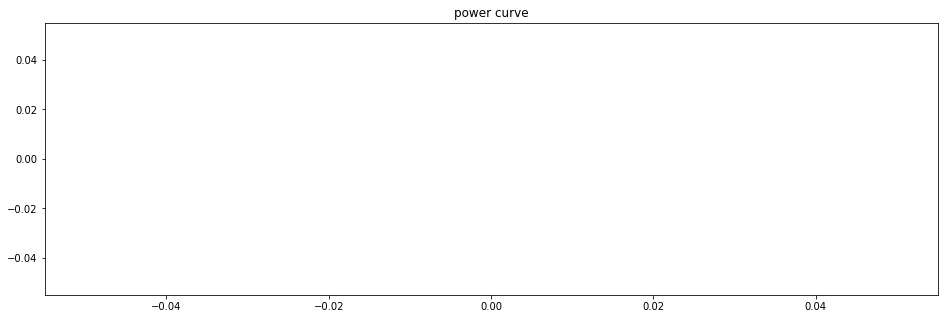

In [ ]:
plt.figure(figsize=(16, 5))
plt.plot(sorted(example["power"])[::-1])
plt.title("power curve")
plt.show()

In [9]:
grouped_df = example.set_index('timestamp').groupby('FileName')\
             .resample('60S')['power', 'heart_rate', 'cadence'].mean().reset_index()

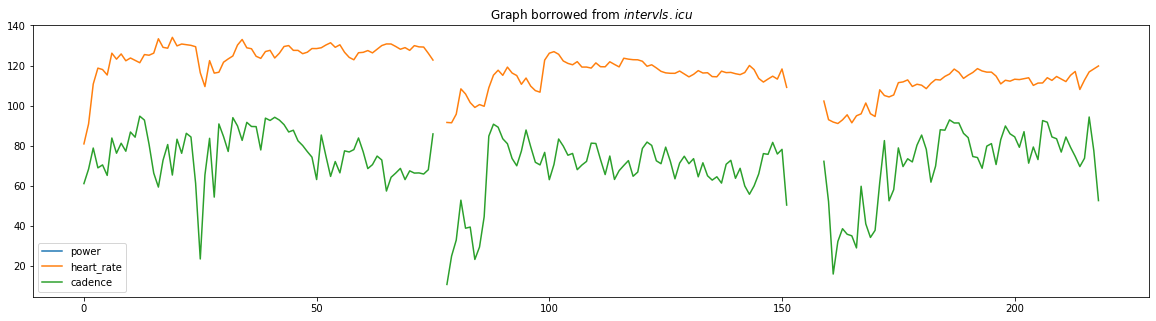

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(100 * (grouped_df['power'] / 202).values, label = "power")
plt.plot(100 * (grouped_df['heart_rate']/ (195-60)).values, label = "heart_rate")
plt.plot(grouped_df['cadence'], label = "cadence")
plt.title("Graph borrowed from $intervls.icu$")
plt.legend()
plt.show()

In [11]:
from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

In [12]:
def ReLU(x):
    return x * (x > 0)

In [13]:
def compute_power(weight, bike_wgt, speed, slope):
    
    # 1) rolling resistance
    C_rr = np.random.uniform(0.0025, 0.004) # coefficient of rolling resistance
    m = weight + bike_wgt # total mass
    g = 9.81

    P_rr = C_rr * m * speed * g

    # 2) Aerodynamic drag
    rho = 1.2 # air density
    C_d = 0.8 # drag coefficient
    A = 0.4 # frontal area

    P_aero = 0.5 * rho * C_d * A * np.power(speed, 3)

    # 3) Gradient resistance
    slope_rad = slope * (np.pi/180)
    P_gr = m * g * speed * np.sin(slope_rad)

    eta = 0.95 # drivetrain efficiency

    P = (P_rr + P_aero + P_gr) / eta

    return max(np.divide(P, weight), 0)

In [14]:
compute_power(weight=85.5, bike_wgt=8.8, speed=5.524, slope=7.097182)

8.391262398769072

In [15]:
def data_prep(df, weight, bike_wgt, rest_hr, max_hr, split = True, has_real_power = True):
    Xy = df[["altitude", "cadence", "enhanced_speed", "current_slope", "heart_rate", "distance", "power"]].copy()
    # heart_rate w.r.t. rest HR and max HR
    Xy["heart_rate"] = 100 * (Xy['heart_rate']/ (max_hr-rest_hr))
    Xy["heart_rate"] = Xy["heart_rate"].bfill()
    Xy["current_slope"] = Xy["current_slope"].fillna(0)
    Xy.loc[(Xy["cadence"].isnull()) & (Xy["enhanced_speed"] == 0), "cadence"] = 0
    Xy["distance"] = Xy["distance"] / 1000
    Xy["power"] = Xy["power"].fillna(0)
    Xy["power"] = Xy["power"]/weight

    # Xy["athlete_weight"] = 85.5
    # Xy["bike_weight"] = 8.8

    Xy = Xy.dropna(how = "any").reset_index(drop = True)

    Xy["estimated_power"] = Xy.apply(lambda row: compute_power(weight = weight, bike_wgt = bike_wgt,
                                                            speed = row["enhanced_speed"],
                                                            slope = row["current_slope"]),
                                    axis = 1)

    X = Xy.drop("power", axis = 1)
    y = Xy["power"]
    
    if split:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)
        return X_train, X_test, y_train, y_test
    else:
        return X, y

In [44]:
def model_pipeline(X_train, X_test, y_train, y_test, weight, early_stop = False):
    # Uneducated guess
    print("RMSE: {:.2f}".format(mean_squared_error(y_train, X_train["estimated_power"], squared=False)))
    print("MAE: {:.2f} W/kg ({:.2f} W)".format(mean_absolute_error(y_train, X_train["estimated_power"]),
                                               mean_absolute_error(y_train, X_train["estimated_power"]) * weight))

    plt.figure(figsize = (16, 5))
    plt.plot(sorted(pd.concat([y_train, y_test], ignore_index=True))[::-1], label = "REAL POWER")
    plt.plot(sorted(pd.concat([X_train, X_test], ignore_index=True)["estimated_power"])[::-1], label = "PREDICTED")
    plt.title("UNEDUCATED GUESS - Test power curve")
    plt.legend()
    plt.show()

    if early_stop:
        return None

    # Initialize a Decision Tree Classifier

    d3 = DecisionTreeRegressor(random_state = 101, criterion = "absolute_error")
    d3.fit(X_train, y_train)
    print("Tree Train RMSE: {:.4f}\n".format((mean_squared_error(y_train, d3.predict(X_train), squared=True))))

    # Compute impurities to look for an adequate pruning term
    path = d3.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    # Plot the impurity level given ccp_alpha
    plt.plot(ccp_alphas[:-1], impurities[:-1], marker = "o", drawstyle = "steps-post")
    plt.xlabel("effective alpha")
    plt.ylabel("total impurity of leaves")
    plt.title("Total Impurity vs effective alpha for training set")
    plt.show()

    # Tree Pruning (we are overfitting - Accuracy: 100% in training)
    tree_params = {"ccp_alpha":[ccp_alphas[impurities < impty].max()
                                for impty in np.linspace(0.1, np.round(impurities.max()/2, 3),
                                                        num = 5)]}

    tree_grid = GridSearchCV(DecisionTreeRegressor(random_state = 101, criterion = "absolute_error"),
                            tree_params, cv = 3, n_jobs = 6, verbose = 10,
                            return_train_score = True)
    tree_grid.fit(X_train, y_train)

    # Show the results
    print("With ReLU")
    print("RMSE: {:.2f}".format(mean_squared_error(y_test, ReLU(tree_grid.best_estimator_.predict(X_test)), squared=True)))
    print("MAE: {:.2f} W/kg ({:.2f} W)".format(mean_absolute_error(y_test, ReLU(tree_grid.best_estimator_.predict(X_test))),
                                               mean_absolute_error(y_test, ReLU(tree_grid.best_estimator_.predict(X_test))) * weight))
    # print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, ReLU(tree_grid.best_estimator_.predict(X_test)))))
    print()
    print("Without ReLU")
    print("RMSE: {:.2f}".format(mean_squared_error(y_test, tree_grid.best_estimator_.predict(X_test), squared=True)))
    print("MAE: {:.2f} W/kg ({:.2f} W)".format(mean_absolute_error(y_test, tree_grid.best_estimator_.predict(X_test)),
                                               mean_absolute_error(y_test, tree_grid.best_estimator_.predict(X_test)) * weight))
    # print("MAPE: {:.2f} %".format(100*mean_absolute_percentage_error(y_test, tree_grid.best_estimator_.predict(X_test))))

    plt.figure(figsize = (16, 5))
    plt.plot(sorted(y_test)[::-1], label = "REAL POWER", lw = 5)
    plt.plot(sorted(ReLU(tree_grid.best_estimator_.predict(X_test)))[::-1], label = "PREDICTED + RELU", lw = 5)
    plt.plot(sorted(tree_grid.best_estimator_.predict(X_test))[::-1], label = "PREDICTED", alpha = .8, ls = "--")
    plt.title("DECISION TREE - Test power curve")
    plt.legend()
    plt.show()

    return tree_grid.best_estimator_

In [ ]:
_, dr = parse_fit.get_dataframes("{}\\16438299806_ACTIVITY.fit".format("\\".join(strava_export_path.split("\\")[:-1] + ["\\data\\DR"])))

RMSE: 1.85
MAE: 1.22 W/kg (104.38 W)


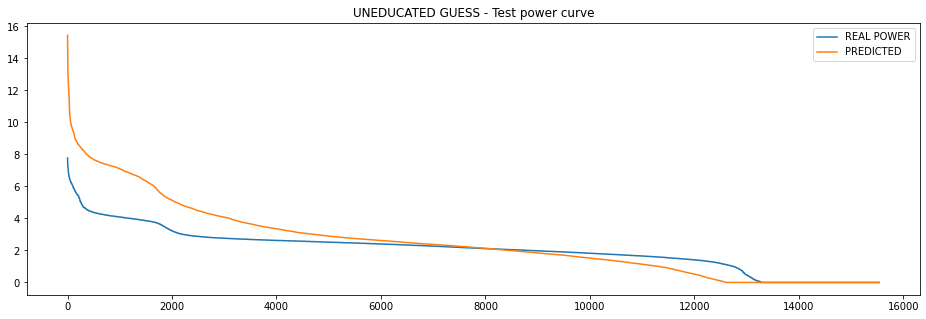

Tree Train RMSE: 0.0000



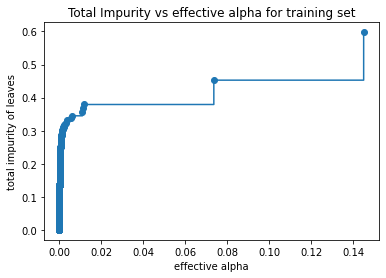

Fitting 3 folds for each of 5 candidates, totalling 15 fits
With ReLU
RMSE: 0.18
MAE: 0.24 W/kg (20.13 W)

Without ReLU
RMSE: 0.18
MAE: 0.24 W/kg (20.13 W)


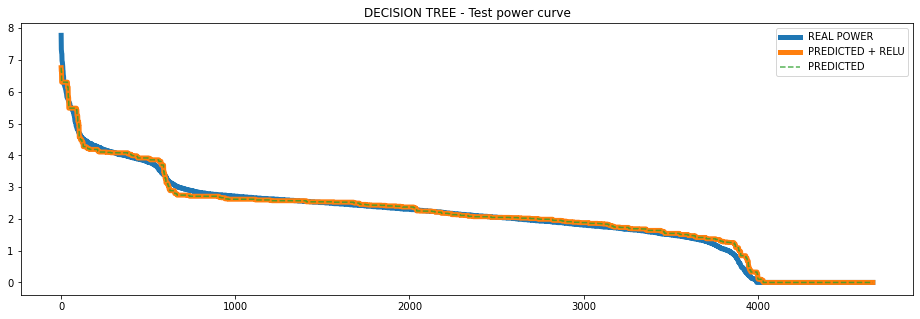

In [75]:
dr_X_train, dr_X_test, dr_y_train, dr_y_test = data_prep(dr, weight = 85.5, bike_wgt = 8.8, rest_hr = 55, max_hr = 195)
model = model_pipeline(dr_X_train, dr_X_test, dr_y_train, dr_y_test, weight = 85.5)

In [76]:
# test on all DR files
for f in os.listdir("\\".join(strava_export_path.split("\\")[:-1] + ["\\data\\DR"])):
    if ".fit" in f:
        _, data = parse_fit.get_dataframes("{}\\{}".format("\\".join(strava_export_path.split("\\")[:-1] + ["\\data\\DR"]), f ))

        X_input, y_input = data_prep(dr, weight = 85.5, bike_wgt = 8.8, rest_hr = 55, max_hr = 195, split = False)

        print("RMSE: {:.2f}".format(mean_squared_error(y_input, model.predict(X_input), squared=True)))
        print("MAE: {:.2f} W/kg ({:.2f} W)".format(mean_absolute_error(y_input, model.predict(X_input)),
                                                mean_absolute_error(y_input, model.predict(X_input)) * 85.5))

RMSE: 0.14
MAE: 0.20 W/kg (17.40 W)
RMSE: 0.14
MAE: 0.20 W/kg (17.40 W)
RMSE: 0.14
MAE: 0.20 W/kg (17.41 W)


Afternoon Ride in the rain🌧
	Zwift avg Watts: 77.59
	MODEL avg Watts: 94.63


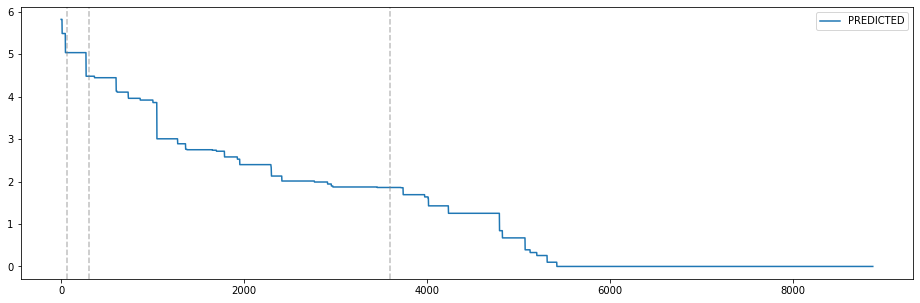

Milano e la sua pellicola di smog
	Zwift avg Watts: 97.22
	MODEL avg Watts: 142.20


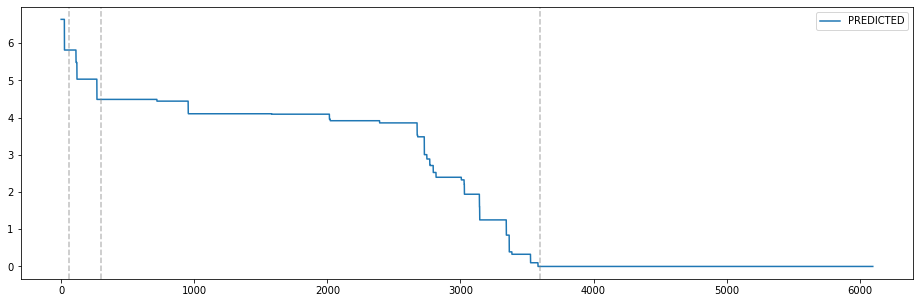

Como in chill🚵‍♂️
	Zwift avg Watts: 101.27
	MODEL avg Watts: 141.79


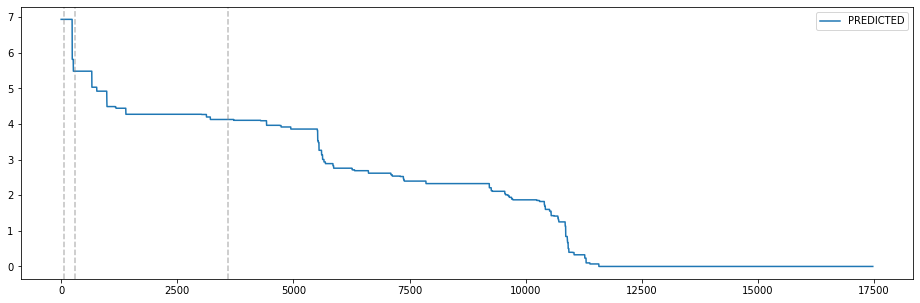

Affezionato alla Brianza + giro turistico in centro
	Zwift avg Watts: 84.44
	MODEL avg Watts: 134.37


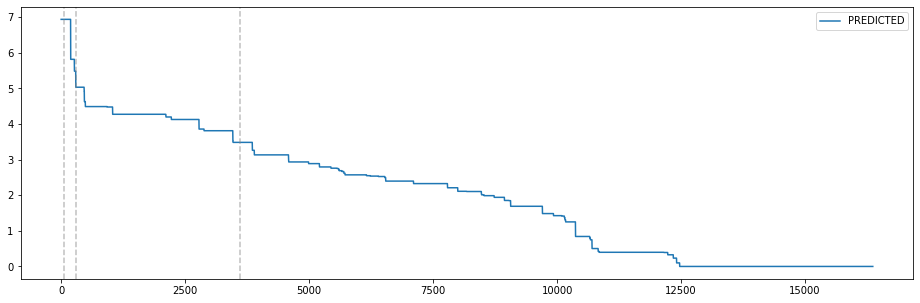

Di corsa per vedere MVDP
	Zwift avg Watts: 135.42
	MODEL avg Watts: 108.07


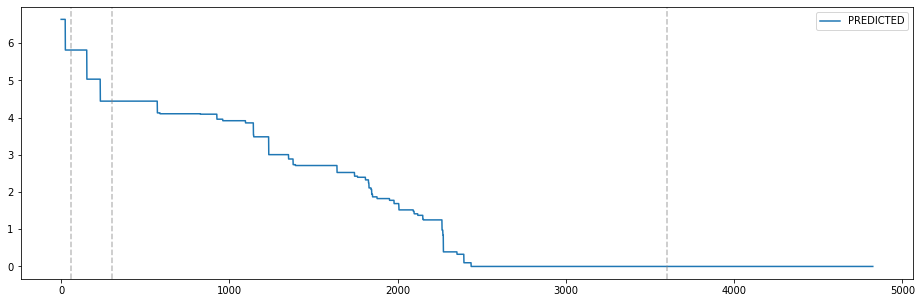

Per chiudere l'anno 
	Didn't work
Il pavese come la bassa veronese
	Zwift avg Watts: 100.53
	MODEL avg Watts: 187.82


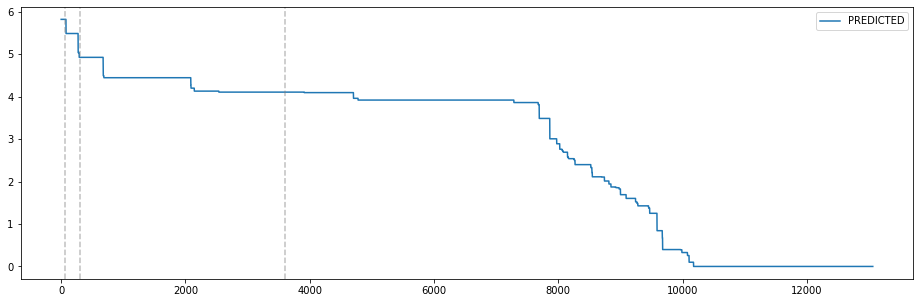

Tempo di tornare a casa
	Zwift avg Watts: 158.07
	MODEL avg Watts: 106.69


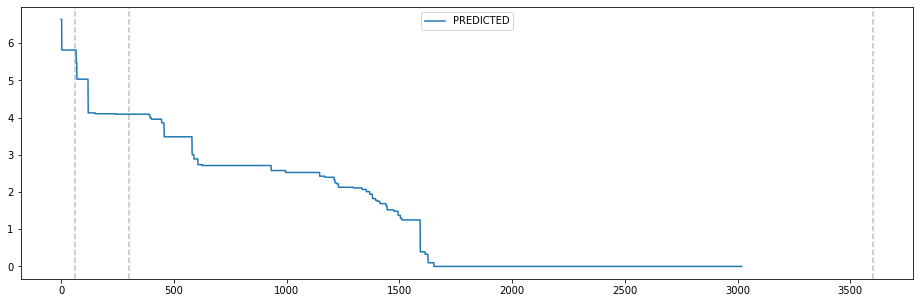

Monte Baldo DH
	Zwift avg Watts: 79.53
	MODEL avg Watts: 76.25


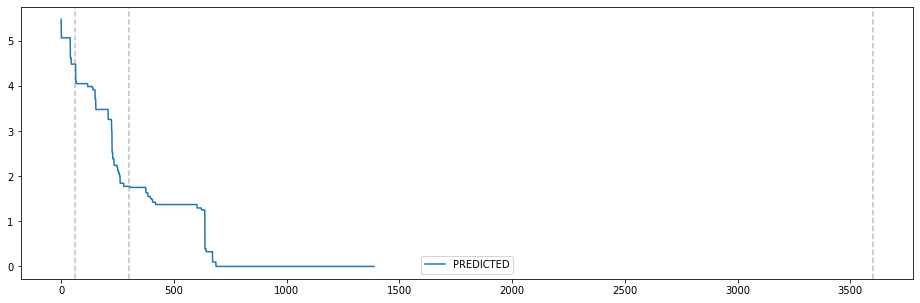

Treni da e per Milano
	Zwift avg Watts: 108.18
	MODEL avg Watts: 114.51


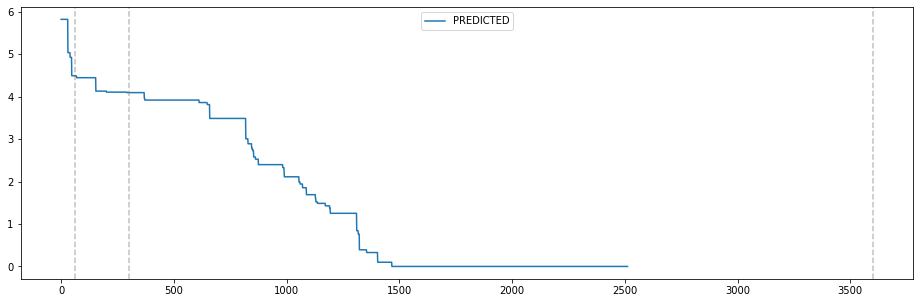

In [165]:
# test on some of my FIT files
sample_activities = activities_df[~(activities_df["Activity Name"].str.contains("Zwift")) &
                                  (activities_df["Average Watts"].notna()) &
                                  (activities_df["Average Heart Rate"].notna())]["Activity Name"].sample(10)


for a in sample_activities:
    print(a)
    
    input_data = slice_parquet_activity(a, col_subset=False)
    if len(input_data) > 0:
        X_input, y_input = data_prep(input_data, weight = 67, bike_wgt = 9.8, rest_hr = 57, max_hr = 195, split = False)

        recording_interval = input_data["timestamp"].diff().dropna().min().seconds
        if X_input.isnull().sum().sum() == 0:
            
            prediction = model.predict(X_input)
            print("\tZwift avg Watts: {:.2f}".format(input_data["Average Watts"].max()))
            print("\tMODEL avg Watts: {:.2f}".format(67 * prediction.mean()))
            
            plt.figure(figsize = (16, 5))
            plt.plot(sorted(prediction, reverse=True), label = "PREDICTED")
            plt.axvline(60 / recording_interval, color = "grey", alpha = .5, ls = "--")
            plt.axvline(300 / recording_interval, color = "grey", alpha = .5, ls = "--")
            plt.axvline(3600 / recording_interval, color = "grey", alpha = .5, ls = "--")
            #plt.xlim(-20, len(X_input) * 1.1)
            #plt.xscale("log")
            plt.legend()
            plt.show()
    else:
        print("\tDidn't work")

In [219]:
def predict_from_tree(tree, instance):
    node = 0  # start from the root
    while tree.children_left[node] != -1:  # while not a leaf
        feature_index = tree.feature[node]
        threshold = tree.threshold[node]
        
        if instance.iloc[feature_index] <= threshold:
            node = tree.children_left[node]
        else:
            node = tree.children_right[node]
    
    # When a leaf is reached
    return tree.value[node][0, 0]

# Example usage
instance = dr_X_test.iloc[100]  # An instance to predict
prediction = predict_from_tree(model.tree_, instance)
print(f"Predicted value: {prediction:.2f} W/kg ({prediction * 85.5:.0f} W)")

Predicted value: 2.18 W/kg (186 W)


In [19]:
df_more_points = example.set_index('timestamp').groupby('FileName')\
             .resample('5S')['power', 'heart_rate', 'cadence'].mean().reset_index()

In [36]:
df_more_points['heart_rate'] = 100 * (grouped_df['heart_rate']/ (195-60))

df_more_points['heart_rate_lag1'] = df_more_points['heart_rate'].shift(1)
df_more_points['heart_rate_lag2'] = df_more_points['heart_rate'].shift(2)

df_more_points['cadence_lag1'] = df_more_points['cadence'].shift(1)
df_more_points['cadence_lag2'] = df_more_points['cadence'].shift(2)

df_more_points = df_more_points.fillna(0)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df_more_points.drop(["FileName", "timestamp", "power"], axis = 1),
                                                    df_more_points['power'],
                                                    test_size = 0.2, shuffle = False)

In [55]:
# Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
lin_mae = mean_absolute_error(y_test, y_pred_lin)
print(f"Linear Regression MAE: {lin_mae:.2f} Watts")

# Support Vector Regression (SVR) Model
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
svr_mae = mean_absolute_error(y_test, y_pred_svr)
print(f"SVR MAE: {svr_mae:.2f} Watts")

Linear Regression MAE: 62.31 Watts
SVR MAE: 43.71 Watts


In [51]:
pd.DataFrame(np.c_[lin_reg.predict(X_test), y_test])

,0,1
0,100.232568,31.2
1,96.215553,13.6
2,102.433899,16.4
3,108.034834,27.4
4,126.900054,36.4
...,...,...
141,136.401989,60.2
142,135.652913,65.4
143,114.436911,56.6
144,-12.010753,0.0


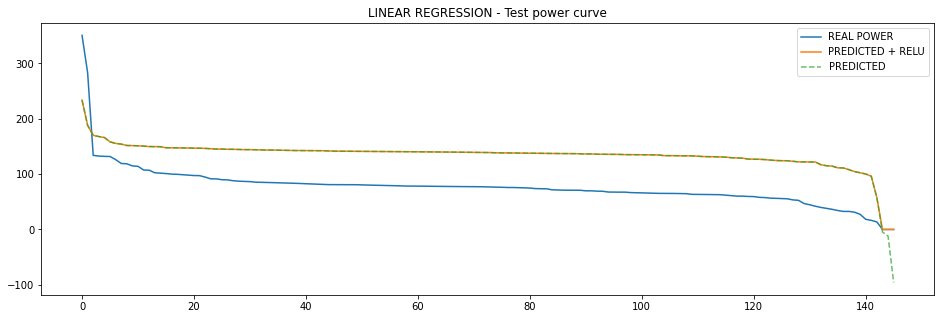

In [48]:
plt.figure(figsize = (16, 5))
plt.plot(sorted(y_test)[::-1], label = "REAL POWER")
plt.plot(sorted(ReLU(lin_reg.predict(X_test)))[::-1], label = "PREDICTED + RELU")
plt.plot(sorted(lin_reg.predict(X_test))[::-1], label = "PREDICTED", alpha = .7, ls = "--")
plt.title("LINEAR REGRESSION - Test power curve")
plt.legend()
plt.show()